In [76]:
# import packages
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from datetime import datetime
from functools import partial
import sys 
import os
import myfunctions #from package

In [77]:
#Problem 1

In [78]:
# Time to maturity
current_date = datetime(2023, 3, 3)
expire_date = datetime(2023, 3, 17)
T = (expire_date - current_date).days / 365
print("Time to maturity: " + str(T))

Time to maturity: 0.038356164383561646


In [79]:
def bsm(option_type, S, X, T, sigma, r, b):
    '''
    option_type: call or put
    S: Underlying price
    X: Strike price
    T: Time to maturity
    sigma: Implied volatility
    r: Risk free rate
    b: Cost of carry
    '''
    d1 = (np.log(S / X) + (b + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    is_call = 1 if option_type == "Call" else -1

    res = is_call * (S * np.e ** ((b - r) * T) * \
                   scipy.stats.norm(0, 1).cdf(is_call * d1) \
                   - X * np.e ** (-r * T) * \
                   scipy.stats.norm(0, 1).cdf(is_call * d2))
    
    return res

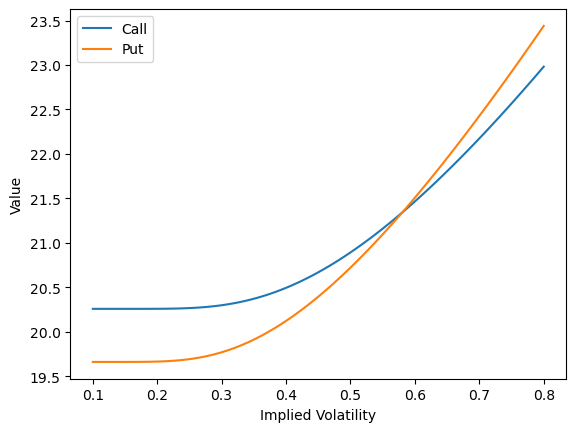

In [80]:
# Assumption: strike price is 180 for put and 150 for call
X_put = 180
X_call = 150
S = 165
r = 0.0525
coupon = 0.0053
b = r - coupon
current_date = datetime(2023, 10, 30)

# For a range of implied volatilities between 10% and 80%
sigmas = np.linspace(0.1, 0.8, 100)

# Calculate the values for put and calls
call_values = []
put_values = []
for sigma in sigmas:
    call_values.append(bsm("Call", S, S-20, T, sigma, r, b))
    put_values.append(bsm("Put", S, S+20, T, sigma, r, b))

# Plot the result
plt.figure()
plt.plot(sigmas, call_values, label="Call")
plt.plot(sigmas, put_values, label="Put")
plt.xlabel("Implied Volatility")
plt.ylabel("Value")
plt.legend()
plt.show()

In [81]:
#Problem 2

In [82]:
def implied_vol(option_type, S, X, T, r, b, market_price, x0=0.5):
    def equation(sigma):
        return bsm(option_type, S, X, T, sigma, r, b) - market_price
    
    # Back solve the Black-Scholes formula to get the implied volatility
    return scipy.optimize.fsolve(equation, x0=x0, xtol=0.00001)[0]

c:\Users\11692\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


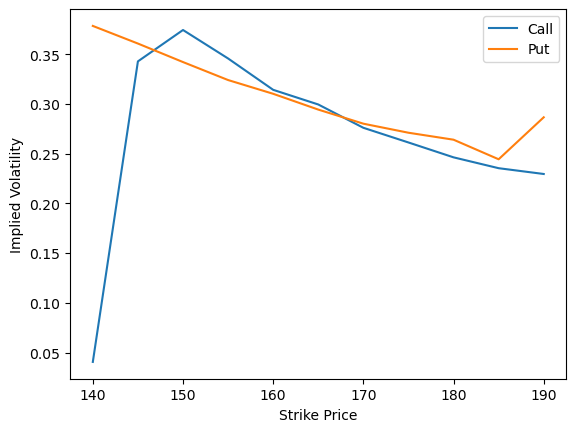

In [83]:
options = pd.read_csv("AAPL_Options.csv", parse_dates=["Expiration"])

S = 170.15
r = 0.0525
coupon = 0.0057
b = r - coupon

# Create lists to store the implied volatilities and strike prices for call and put
implied_vols_call = []
implied_vols_put = []
strike_prices_call = []
strike_prices_put = []

# Calculate the implied volatilities for each option
for i in range(len(options)):
    option_type = options["Type"][i]
    X = options["Strike"][i]
    T = (options["Expiration"][i] - current_date).days / 365
    market_price = options["Last Price"][i]
    sigma = implied_vol(option_type, S, X, T, r, b, market_price)
    if option_type == "Call":
        implied_vols_call.append(sigma)
        strike_prices_call.append(X)
    else:
        implied_vols_put.append(sigma)
        strike_prices_put.append(X)

# Plot the result
plt.figure()
plt.plot(strike_prices_call, implied_vols_call, label="Call")
plt.plot(strike_prices_put, implied_vols_put, label="Put")
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.legend()
plt.show()

In [84]:
#Problem 3

In [85]:
def calculate_sim_values(portfolios, sim_prices, days_ahead=0):
    sim_values = pd.DataFrame(index=portfolios.index, 
                              columns=list(range(sim_prices.shape[0])))
    sim_prices = np.array(sim_prices)
    for i in portfolios.index:
        if portfolios["Type"][i] == "Stock":
            # For stock, the single value is its price
            single_values = sim_prices
        else:
            # For option, calculate values with gbsm method
            option_type = portfolios["OptionType"][i]
            S = sim_prices
            X = portfolios["Strike"][i]
            T = ((portfolios["ExpirationDate"][i] - current_date).days - days_ahead) / 365
            sigma = portfolios["ImpliedVol"][i]
            option_values = bsm(option_type, S, X, T, sigma, r, b)
            single_values = option_values
    
        # Calculate the total values based on holding
        sim_values.loc[i, :] = portfolios["Holding"][i] * single_values
  
    # Combine the values for same portfolios
    sim_values['Portfolio'] = portfolios['Portfolio']
    return sim_values.groupby('Portfolio').sum()

In [86]:
# Read the CSV file into a DataFrame
portfolios = pd.read_csv("problem3.csv", parse_dates=["ExpirationDate"])

# Define a function to calculate implied volatility for a row in the DataFrame
def calculate_implied_vol(row):
    option_type = row["OptionType"]
    X = row["Strike"]
    T = (row["ExpirationDate"] - current_date).days / 365
    market_price = row["CurrentPrice"]
    # Compute implied volatility using the implied_vol function
    return implied_vol(option_type, S, X, T, r, b, market_price)

# Apply the function across the DataFrame to calculate implied volatility for each row
portfolios["ImpliedVol"] = portfolios.apply(calculate_implied_vol, axis=1)

c:\Users\11692\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


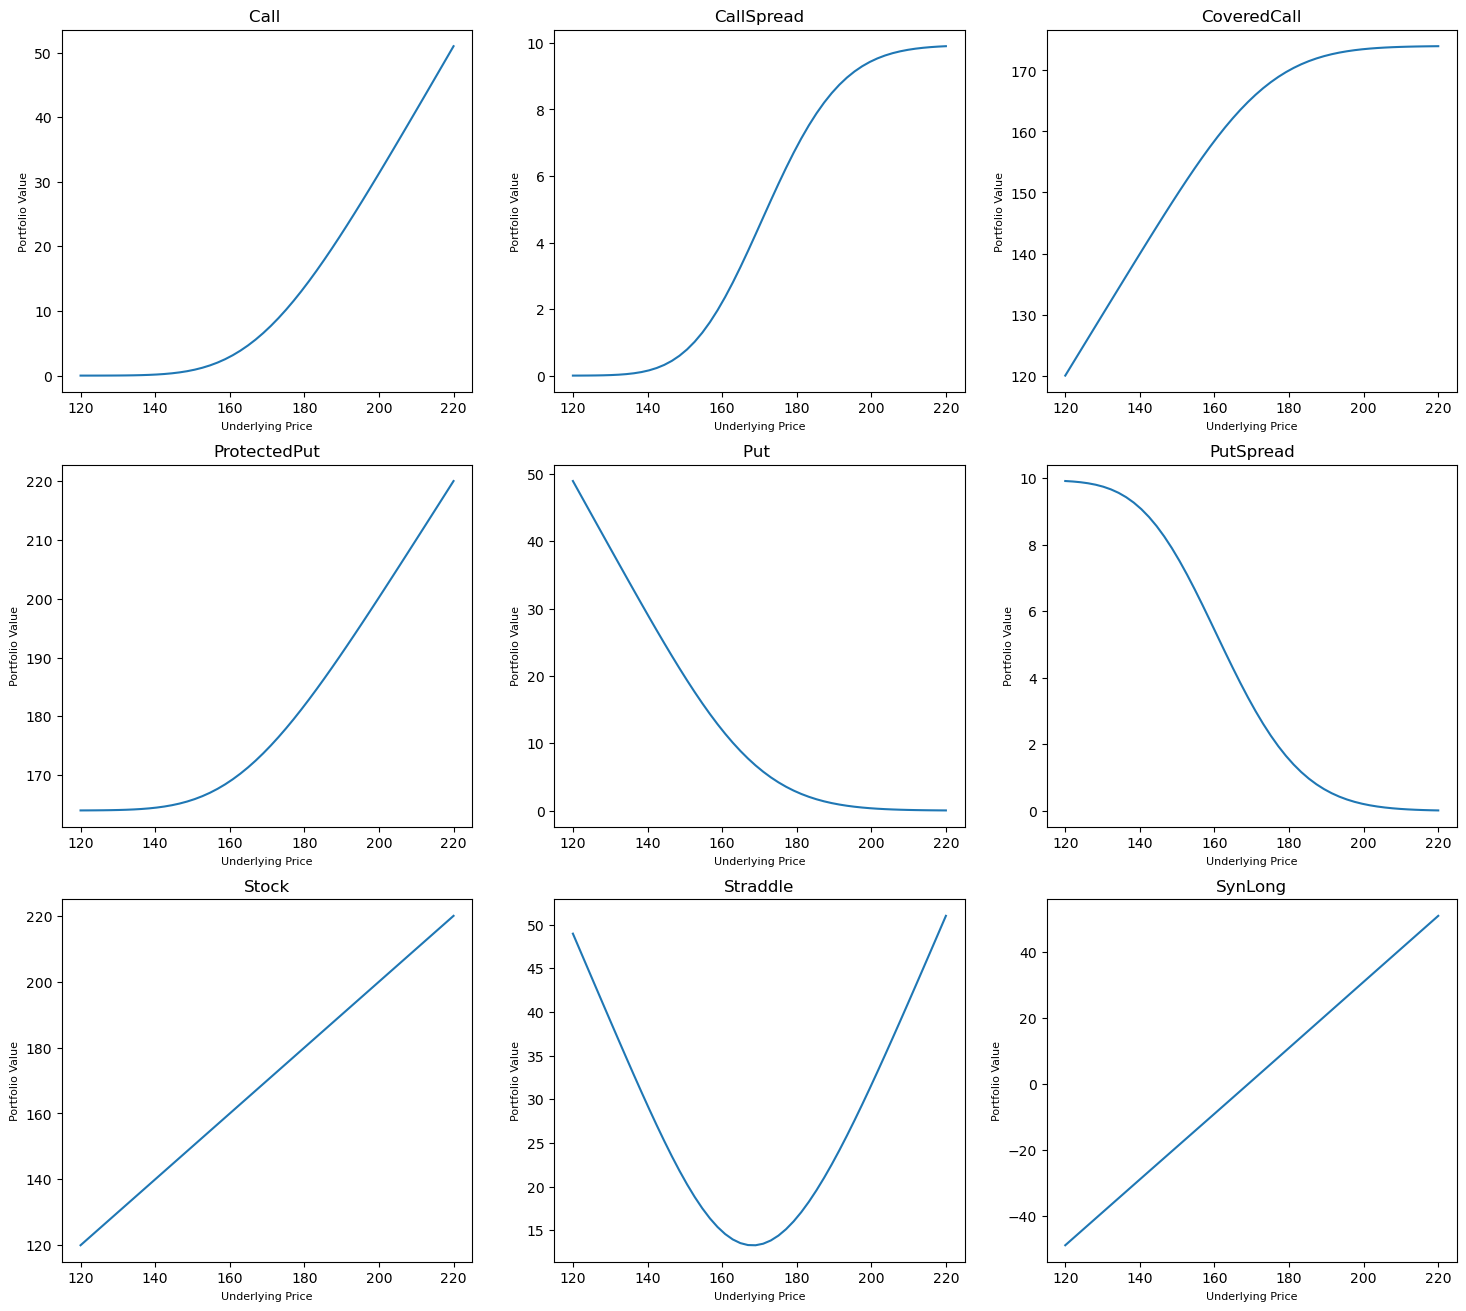

In [87]:
# Simulate the price in 120-220
sim_prices = np.linspace(120, 220, 50)

# Calculate stock and option values
sim_values = calculate_sim_values(portfolios, sim_prices)

# Plot for each portfolio
fig, axes = plt.subplots(3, 3, figsize=(18, 16))
idx = 0
for portfolio, dataframe in sim_values.groupby('Portfolio'):
    i, j = idx // 3, idx % 3
    ax = axes[i][j]
    ax.plot(sim_prices, dataframe.iloc[0, :].values)
    ax.set_title(portfolio)
    ax.set_xlabel('Underlying Price', fontsize=8)
    ax.set_ylabel('Portfolio Value', fontsize=8)
    idx += 1

In [88]:
daily_prices = pd.read_csv("DailyPrices.csv")
#log return calculation
log_returns = np.log(daily_prices['AAPL']/daily_prices['AAPL'].shift(1)).dropna()
demeaned_returns = log_returns - np.mean(log_returns)
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(demeaned_returns, order=(1,0,0)).fit()

c:\Users\11692\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\11692\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\11692\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [89]:
n_forecast = 10
sim = 1000
phi = model.params[1]
beta = model.params[0]
sigma = model.resid.std()

In [90]:
# Generate the simulated returns
simulated_returns = np.zeros((n_forecast,sim))
np.random.seed(0)
for j in range(sim):
    simulated_returns[0,j]= beta + phi * demeaned_returns.iloc[-1] + sigma * norm.rvs()
    for i in range(n_forecast-1):
        simulated_returns[i+1,j] = beta + phi * simulated_returns[i,j] + sigma * norm.rvs()

In [91]:
price_series = pd.DataFrame(daily_prices['AAPL'].iloc[-1] * np.exp(simulated_returns.cumsum(axis=0)))
sim_prices = price_series.loc[9:].values[0]

In [92]:
# Calculate the current values and sim values
portfolios["CurrentValue"] = portfolios["CurrentPrice"] * portfolios["Holding"]
curr_values = portfolios.groupby('Portfolio')['CurrentValue'].sum()
sim_values = calculate_sim_values(portfolios, sim_prices, 10)

# Calculate the value difference
sim_value_changes = (sim_values.T - curr_values).T

# Calculate the Mean, VaR and ES, and print the results
result = pd.DataFrame(index=sim_value_changes.index)
result['Mean'] = sim_value_changes.mean(axis=1)
result['VaR'] = sim_value_changes.apply(lambda x:myfunctions.calculate_var(x, 0), axis=1)
result['ES'] = sim_value_changes.apply(lambda x:myfunctions.calculate_es(x), axis=1)
print(result)

                  Mean        VaR         ES
Portfolio                                   
Call          2.727880   5.261889   5.929010
CallSpread    0.835606   2.932288   3.448473
CoveredCall   1.975570   7.492632  10.642601
ProtectedPut  3.240699   6.562626   7.647089
Put          -1.394301   5.466960   5.735681
PutSpread    -0.572256   2.711849   2.886343
Stock         4.314309  11.219996  14.722912
Straddle      1.333579   1.591310   1.599497
SynLong       4.122181  11.396872  14.884558
